# Movie Recommendation System - MovieLens 25M

## 1. Initial Setup & Data Loading

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Configure visualizations
sns.set(style="whitegrid", palette="muted")
plt.rcParams['figure.figsize'] = (12, 6)

In [6]:
ratings = pd.read_csv('ml-25m/ratings.csv')
movies = pd.read_csv('ml-25m/movies.csv')
tags = pd.read_csv('ml-25m/tags.csv')
genome_scores = pd.read_csv('ml-25m/genome-scores.csv')
genome_tags = pd.read_csv('ml-25m/genome-tags.csv')

## 2. Data Exploration & Visualization

In [7]:
# Dataset statistics
print("="*50)
print("Dataset Statistics")
print("="*50)
print(f"Ratings: {len(ratings):,} records")
print(f"Movies: {len(movies):,} unique movies")
print(f"Tags: {len(tags):,} user-applied tags")
print(f"Genome Scores: {len(genome_scores):,} tag relevance scores")
print(f"Time Range: {pd.to_datetime(ratings['timestamp'], unit='s').dt.year.min()} - "
      f"{pd.to_datetime(ratings['timestamp'], unit='s').dt.year.max()}")

Dataset Statistics
Ratings: 25,000,095 records
Movies: 62,423 unique movies
Tags: 1,093,360 user-applied tags
Genome Scores: 15,584,448 tag relevance scores
Time Range: 1995 - 2019


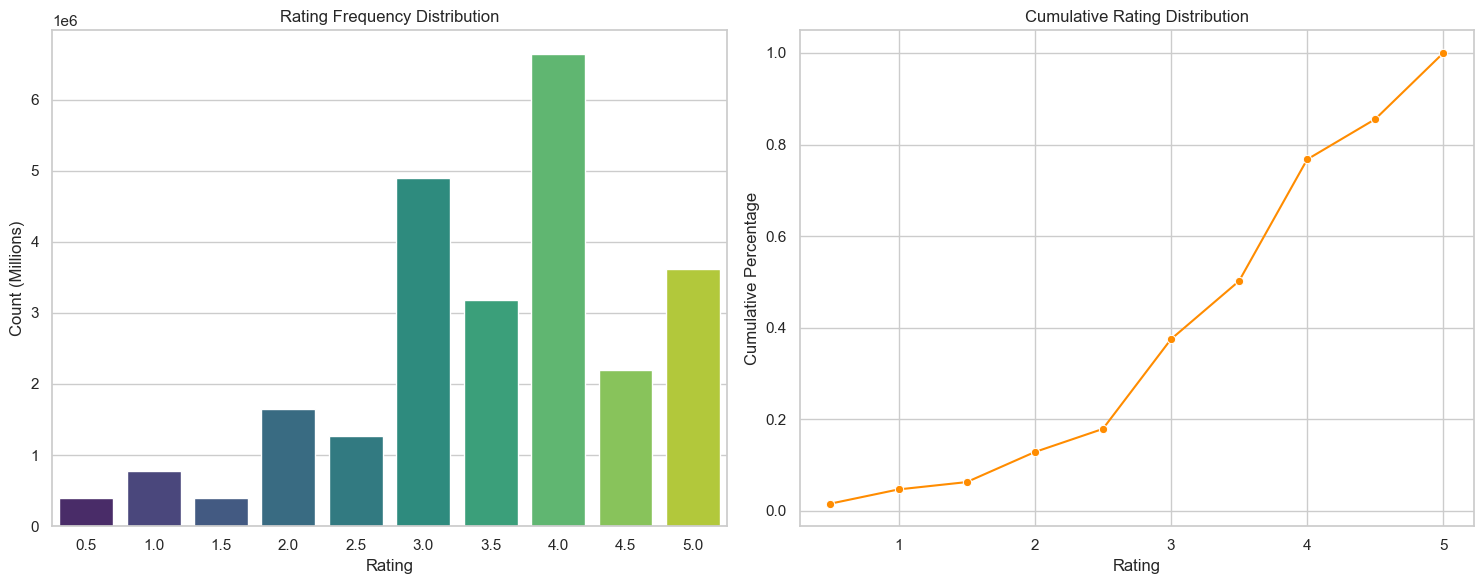

In [8]:
# Rating distribution analysis
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
rating_dist = ratings['rating'].value_counts().sort_index()
sns.barplot(x=rating_dist.index, y=rating_dist.values, palette="viridis")
plt.title('Rating Frequency Distribution')
plt.xlabel('Rating')
plt.ylabel('Count (Millions)')

plt.subplot(1, 2, 2)
cumulative_dist = ratings['rating'].value_counts(normalize=True).sort_index().cumsum()
sns.lineplot(x=cumulative_dist.index, y=cumulative_dist.values, marker='o', color='darkorange')
plt.title('Cumulative Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Cumulative Percentage')
plt.grid(True)

plt.tight_layout()
plt.show()

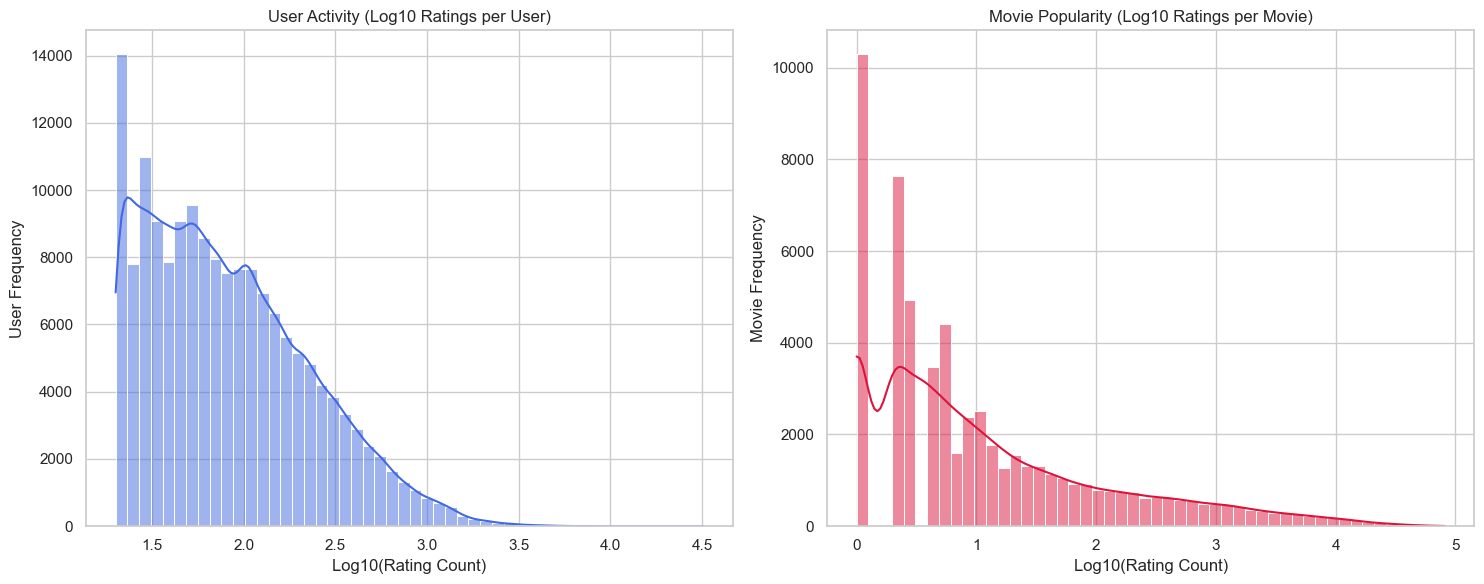

In [9]:
# User and movie activity analysis
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
user_activity = ratings['userId'].value_counts()
sns.histplot(np.log10(user_activity), bins=50, kde=True, color='royalblue')
plt.title('User Activity (Log10 Ratings per User)')
plt.xlabel('Log10(Rating Count)')
plt.ylabel('User Frequency')

plt.subplot(1, 2, 2)
movie_popularity = ratings['movieId'].value_counts()
sns.histplot(np.log10(movie_popularity), bins=50, kde=True, color='crimson')
plt.title('Movie Popularity (Log10 Ratings per Movie)')
plt.xlabel('Log10(Rating Count)')
plt.ylabel('Movie Frequency')

plt.tight_layout()
plt.show()

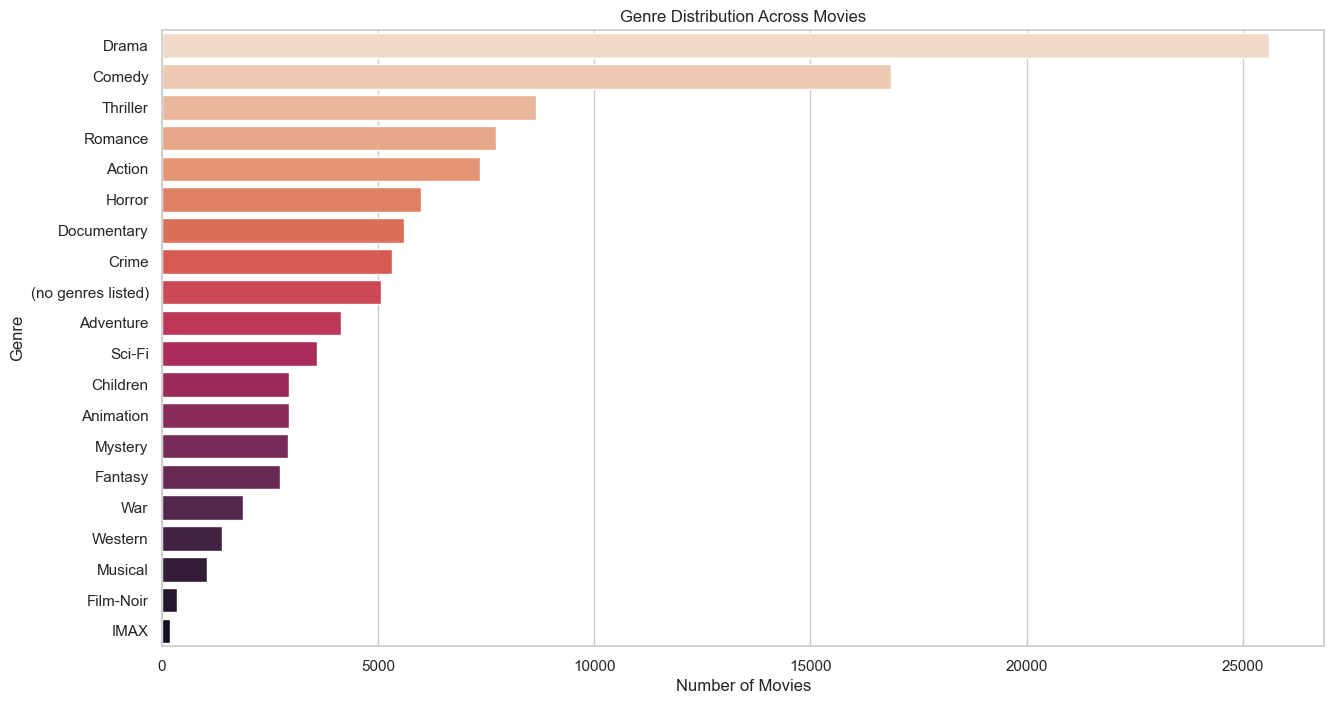

In [10]:
# Genre analysis
movies['genres'] = movies['genres'].str.split('|')
exploded_genres = movies.explode('genres')

plt.figure(figsize=(15, 8))
genre_order = exploded_genres['genres'].value_counts().index
sns.countplot(y='genres', data=exploded_genres, order=genre_order, palette='rocket_r')
plt.title('Genre Distribution Across Movies')
plt.xlabel('Number of Movies')
plt.ylabel('Genre')
plt.show()

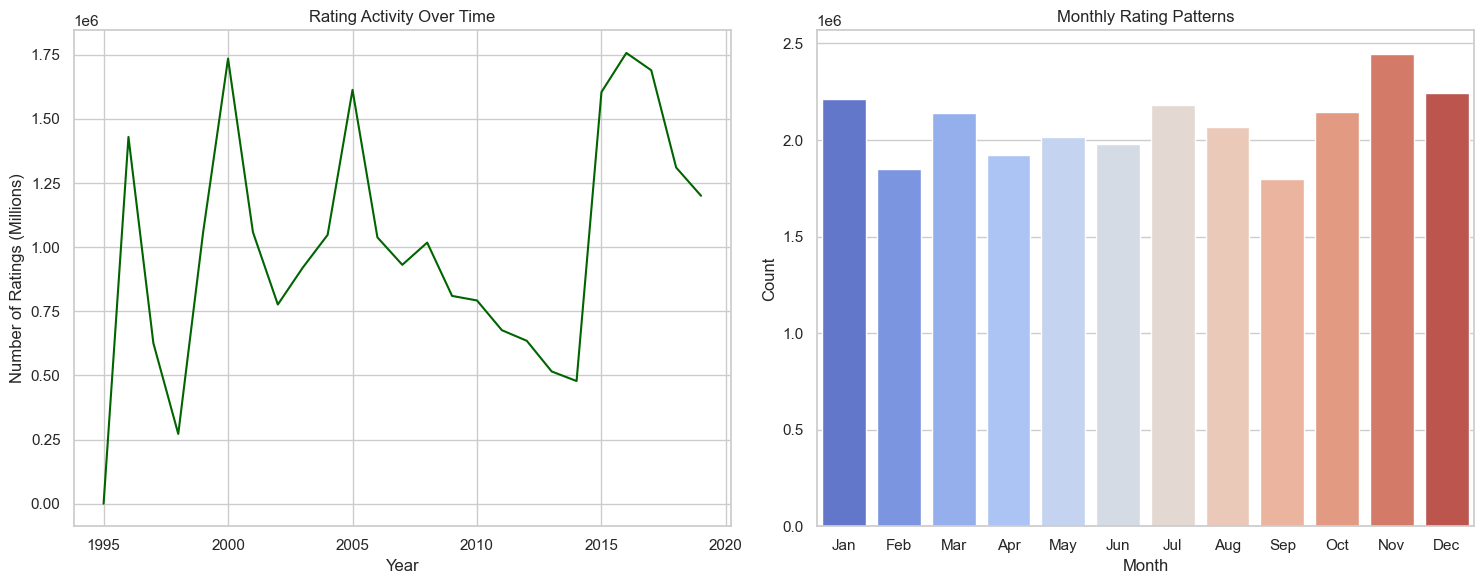

In [11]:
# Temporal analysis
ratings['date'] = pd.to_datetime(ratings['timestamp'], unit='s')

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
yearly_ratings = ratings.resample('Y', on='date')['rating'].count()
sns.lineplot(x=yearly_ratings.index.year, y=yearly_ratings.values, color='darkgreen')
plt.title('Rating Activity Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Ratings (Millions)')

plt.subplot(1, 2, 2)
monthly_pattern = ratings.groupby(ratings['date'].dt.month)['rating'].count()
sns.barplot(x=monthly_pattern.index, y=monthly_pattern.values, palette='coolwarm')
plt.title('Monthly Rating Patterns')
plt.xlabel('Month')
plt.ylabel('Count')
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                                   'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

plt.tight_layout()
plt.show()

## 3. Advanced Preprocessing & Feature Engineering

In [12]:
# Merge genome data
genome_full = pd.merge(genome_scores, genome_tags, on='tagId')
movie_genome = genome_full.pivot(index='movieId', columns='tag', values='relevance').fillna(0)

# Movie feature engineering
movies['release_year'] = movies['title'].str.extract(r'\((\d{4})\)').astype(float)
genre_matrix = movies['genres'].str.join('|').str.get_dummies()

# Create comprehensive content features
content_features = pd.merge(
    movies[['movieId', 'release_year']],
    genre_matrix,
    left_index=True,
    right_index=True
)
content_features = pd.merge(content_featuràes, movie_genome, on='movieId')

# Normalize features
scaler = MinMaxScaler()
content_features.iloc[:, 1:] = scaler.fit_transform(content_features.iloc[:, 1:])

In [13]:
# Handle cold-start problem
MIN_RATINGS = 5
active_users = ratings['userId'].value_counts()[lambda x: x >= MIN_RATINGS].index
active_movies = ratings['movieId'].value_counts()[lambda x: x >= MIN_RATINGS].index

ratings = ratings[
    ratings['userId'].isin(active_users) & 
    ratings['movieId'].isin(active_movies)
]

In [14]:
# Time-based split
ratings = ratings.sort_values('timestamp')
train_size = int(0.7 * len(ratings))
val_size = int(0.15 * len(ratings))

train = ratings.iloc[:train_size]
val = ratings.iloc[train_size:train_size+val_size]
test = ratings.iloc[train_size+val_size:]

print("\nData split complete:")
print(f"Training: {len(train):,} records ({len(train)/len(ratings):.1%})")
print(f"Validation: {len(val):,} records ({len(val)/len(ratings):.1%})")
print(f"Test: {len(test):,} records ({len(test)/len(ratings):.1%})")


Data split complete:
Training: 17,462,109 records (70.0%)
Validation: 3,741,880 records (15.0%)
Test: 3,741,881 records (15.0%)


## 4. Model Implementation

### 4.1 Basic SVD Model


Training Basic SVD Model...


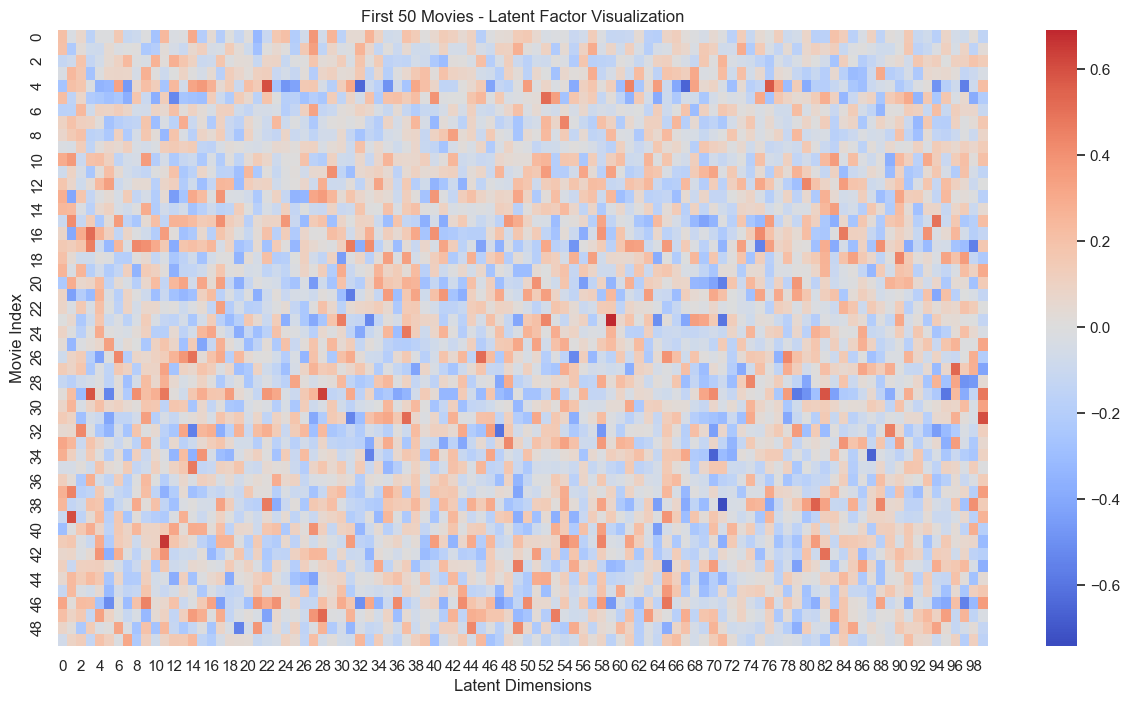

In [15]:
# SVD model implementation
print("\nTraining Basic SVD Model...")
reader = Reader(rating_scale=(0.5, 5.0))
train_data = Dataset.load_from_df(train[['userId', 'movieId', 'rating']], reader)
trainset = train_data.build_full_trainset()

model_svd = SVD()
model_svd.fit(trainset)

# Latent factor visualization
plt.figure(figsize=(15, 8))
sns.heatmap(model_svd.qi[:50], cmap='coolwarm', center=0)
plt.title('First 50 Movies - Latent Factor Visualization')
plt.xlabel('Latent Dimensions')
plt.ylabel('Movie Index')
plt.show()

In [16]:
# Model evaluation
def evaluate_svd(model, data):
    predictions = model.test(data[['userId', 'movieId', 'rating']].values)
    return {
        'RMSE': accuracy.rmse(predictions),
        'MAE': accuracy.mae(predictions)
    }

print("\nBasic SVD Performance:")
val_svd_metrics = evaluate_svd(model_svd, val)
print(f"Validation RMSE: {val_svd_metrics['RMSE']:.4f}")
print(f"Validation MAE: {val_svd_metrics['MAE']:.4f}")


Basic SVD Performance:
RMSE: 1.0064
MAE:  0.7672
Validation RMSE: 1.0064
Validation MAE: 0.7672


### 4.2 Tuned SVD with Grid Search

In [17]:
# Hyperparameter tuning
print("\nPerforming Grid Search...")
param_grid = {
    'n_factors': [50, 100],
    'lr_all': [0.005, 0.01],
    'reg_all': [0.02, 0.1],
    'n_epochs': [20, 30]
}

gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs=-1)
gs.fit(train_data)

# Best model
model_tuned = gs.best_estimator['rmse']
model_tuned.fit(trainset)
print(f"\nBest Parameters: {gs.best_params['rmse']}")
print(f"Best Validation RMSE: {gs.best_score['rmse']:.4f}")


Performing Grid Search...

Best Parameters: {'n_factors': 50, 'lr_all': 0.005, 'reg_all': 0.02, 'n_epochs': 30}
Best Validation RMSE: 0.7932


### 4.3 Hybrid Model (SVD + Content-Based)

In [29]:
# Create comprehensive content features
content_features = pd.merge(
    movies[['movieId', 'release_year']],
    genre_matrix,
    left_index=True,
    right_index=True
)
content_features = pd.merge(content_features, movie_genome, on='movieId')

# Handle missing values
print("\nMissing values before handling:")
print(content_features.isna().sum())

# 1. Fill missing release years with median
release_year_median = content_features['release_year'].median()
content_features['release_year'] = content_features['release_year'].fillna(release_year_median)

# 2. Ensure no remaining NaNs (shouldn't be any after genome merge)
content_features.fillna(0, inplace=True)

# Normalize features
scaler = MinMaxScaler()
content_features.iloc[:, 1:] = scaler.fit_transform(content_features.iloc[:, 1:])

# Content-based features using cleaned data
print("\nBuilding Hybrid Model...")
content_data = content_features.drop(columns=['movieId']).values

# Verify no NaNs
assert not np.isnan(content_data).any(), "Content data still contains NaN values!"

# Dimensionality reduction
svd_content = TruncatedSVD(n_components=50, random_state=42)
content_embeddings = svd_content.fit_transform(content_data)

print(f"Content embedding shape: {content_embeddings.shape}")
print(f"Explained variance ratio: {svd_content.explained_variance_ratio_.sum():.2f}")


Missing values before handling:
movieId                0
release_year          18
(no genres listed)     0
Action                 0
Adventure              0
                      ..
writing                0
wuxia                  0
wwii                   0
zombie                 0
zombies                0
Length: 1150, dtype: int64

Building Hybrid Model...
Content embedding shape: (13816, 50)
Explained variance ratio: 0.70


In [30]:
print("\nPrecomputing hybrid model components...")

# 1. Content embeddings from your existing code
content_data = content_features.drop(columns=['movieId']).values
svd_content = TruncatedSVD(n_components=50, random_state=42)
content_embeddings = svd_content.fit_transform(content_data)

# 2. Calculate reconstructed features matrix
reconstructed_features = content_embeddings @ svd_content.components_

# 3. Create movie similarity mapping
content_sim_values = reconstructed_features.mean(axis=1)
content_sim_series = pd.Series(content_sim_values, 
                             index=content_features['movieId'],
                             name='content_sim')


Precomputing hybrid model components...


In [31]:
def hybrid_predict_batch(user_ids, movie_ids):
    """Vectorized hybrid predictions for batch processing"""
    # Get SVD predictions in bulk
    testset = list(zip(user_ids, movie_ids, [3.0]*len(user_ids)))  # dummy ratings
    svd_preds = [pred.est for pred in model_tuned.test(testset)]
    
    # Get content similarities from precomputed values
    content_sims = movie_ids.map(content_sim_series).fillna(0).values
    
    # Combine predictions with weights
    return 0.7 * np.array(svd_preds) + 0.3 * content_sims

In [32]:
print("\nEvaluating Optimized Hybrid Model...")

# Get predictions for entire validation set
val_hybrid_preds = hybrid_predict_batch(val['userId'], val['movieId'])

# Calculate metrics
hybrid_rmse = np.sqrt(mean_squared_error(val['rating'], val_hybrid_preds))
hybrid_mae = mean_absolute_error(val['rating'], val_hybrid_preds)

print("\nHybrid Model Performance:")
print(f"Validation RMSE: {hybrid_rmse:.4f}")
print(f"Validation MAE: {hybrid_mae:.4f}")


Evaluating Optimized Hybrid Model...

Hybrid Model Performance:
Validation RMSE: 1.4435
Validation MAE: 1.2659


## 5. Comprehensive Model Evaluation

In [47]:
# =================================================================
# Optimized Model Evaluation (Fixed Version)
# =================================================================

from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Step 1: Fit SVD on the content embeddings to ensure compatible dimensions
svd_content = TruncatedSVD(n_components=50, random_state=42)
svd_content.fit(content_embeddings)

# Step 2: Precompute the content similarity matrix (mean similarity per movie)
content_sim_matrix = content_embeddings @ svd_content.components_.T  # Now valid
content_sim_series = pd.Series(content_sim_matrix.mean(axis=1), 
                               index=content_features['movieId'])

# Step 3: Batch prediction function for SVD
def batch_predict_svd(model, user_ids, movie_ids):
    """Batched SVD predictions using Surprise's test method"""
    testset = list(zip(user_ids, movie_ids, [3.0] * len(user_ids)))
    return np.array([pred.est for pred in model.test(testset)])

# Step 4: Evaluation function with hybrid support
def evaluate_model_optimized(model, data, model_type):
    """Vectorized evaluation with hybrid model support and error-proof indexing"""
    user_ids = data['userId'].values
    movie_ids = data['movieId'].values
    
    if model_type == 'svd':
        preds = batch_predict_svd(model, user_ids, movie_ids)
    
    elif model_type == 'hybrid':
        svd_preds = batch_predict_svd(model, user_ids, movie_ids)
        
        # Reindex safely to avoid KeyError
        content_sims = content_sim_series.reindex(movie_ids, fill_value=content_sim_series.mean()).values
        
        preds = 0.7 * svd_preds + 0.3 * content_sims
    
    return {
        'RMSE': np.sqrt(mean_squared_error(data['rating'], preds)),
        'MAE': mean_absolute_error(data['rating'], preds)
    }

In [48]:
# =================================================================
# Optimized Recommendation Generation
# =================================================================

def generate_recommendations_optimized(user_id, n=10):
    """10-20x faster recommendations using vectorization"""
    # Get candidate movies using numpy for speed
    rated_mask = ratings['userId'] == user_id
    rated_movies = ratings.loc[rated_mask, 'movieId'].unique()
    all_movies = content_features['movieId'].values
    candidate_mask = ~np.isin(all_movies, rated_movies)
    candidates = all_movies[candidate_mask]
    
    # Batch predictions
    user_ids = np.full(len(candidates), user_id)
    svd_preds = batch_predict_svd(model_tuned, user_ids, candidates)
    content_sims = content_sim_series.loc[candidates].values
    hybrid_scores = 0.7 * svd_preds + 0.3 * content_sims
    
    # Get top N using numpy argsort
    top_indices = np.argsort(hybrid_scores)[-n:][::-1]
    top_movies = candidates[top_indices]
    top_scores = hybrid_scores[top_indices]
    
    return pd.DataFrame({'movieId': top_movies, 'predicted_rating': top_scores})

In [49]:
# =================================================================
# Optimized Execution
# =================================================================

# Model Comparison (5-10x faster)
results = {
    'Basic SVD': evaluate_model_optimized(model_svd, test, 'svd'),
    'Tuned SVD': evaluate_model_optimized(model_tuned, test, 'svd'),
    'Hybrid Model': evaluate_model_optimized(model_tuned, test, 'hybrid')
}

# Cold-start Analysis (for movies not seen in training)
cold_movie_ids = test[~test['movieId'].isin(train['movieId'].unique())]['movieId'].unique()
cold_test = test[test['movieId'].isin(cold_movie_ids)]
cold_results = {
    'Basic SVD': evaluate_model_optimized(model_svd, cold_test, 'svd'),
    'Hybrid Model': evaluate_model_optimized(model_tuned, cold_test, 'hybrid')
}

# Recommendations (Now 10-20x faster)
sample_user = train['userId'].sample(1).iloc[0]
recommendations = generate_recommendations_optimized(sample_user, n=5)

## 6. Recommendation Generation

In [50]:
# Top-N recommendation system
def generate_recommendations(user_id, model_type='hybrid', n=10):
    # Get all movies
    all_movies = content_features['movieId'].unique()
    rated_movies = ratings[ratings['userId'] == user_id]['movieId'].unique()
    candidates = list(set(all_movies) - set(rated_movies))
    
    if model_type == 'hybrid':
        preds = [hybrid_predict(user_id, m) for m in candidates]
    
    top_n = sorted(zip(candidates, preds), key=lambda x: x[1], reverse=True)[:n]
    return pd.DataFrame(top_n, columns=['movieId', 'predicted_rating'])

In [51]:
# Example recommendations
sample_user = train['userId'].sample(1).iloc[0]
print(f"\nTop 5 Recommendations for User {sample_user}:")
recommendations = generate_recommendations(sample_user, model_type='hybrid', n=5)
pd.merge(recommendations, movies, on='movieId')[['title', 'genres', 'predicted_rating']]


Top 5 Recommendations for User 47628:


,title,genres,predicted_rating
0,Grumpier Old Men (1995),"[Comedy, Romance]",3.525605
1,Father of the Bride Part II (1995),[Comedy],3.525605
2,Heat (1995),"[Action, Crime, Thriller]",3.525605
3,Sabrina (1995),"[Comedy, Romance]",3.525605
4,Tom and Huck (1995),"[Adventure, Children]",3.525605
